In [1]:
import sys
import time
sys.path.append("..")
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split

from helper import object_map
from helper import ModelWrapper
from helper import simple_dense_model, simple_conv_model, conv_model, residual_model, bottleneck_model
from utils import plot_history

2023-05-08 12:23:56.115535: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-08 12:23:56.679053: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib/cuda/include:/usr/lib/cuda/lib64::/usr/local/cuda/extras/CUPTI/lib64
2023-05-08 12:23:56.679110: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib/cuda/include:/usr/lib/cuda/lib64::/usr/loca

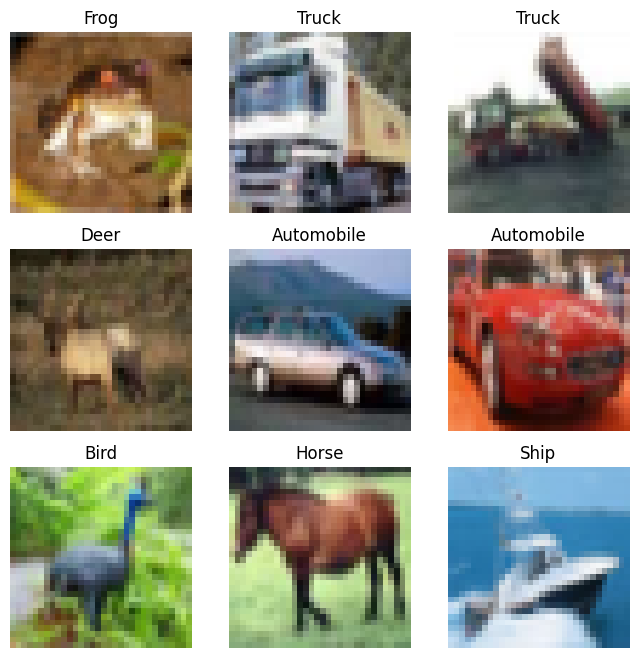

In [2]:
# Download the data and split test set to validation and test set
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()
X_valid, X_test, y_valid, y_test = train_test_split(X_test, 
                                                    y_test, 
                                                    test_size=0.5, 
                                                    stratify=y_test, 
                                                    random_state=47)

BATCH_SIZE = 512
IMG_SHAPE = X_train.shape[1:]

# Show a small sample of the dataset
plt.figure(figsize=(8,8))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.title(object_map[y_train[i][0]])
    plt.imshow(X_train[i])
    plt.axis("off")
plt.show()

In [ ]:
# Metrics
accuracies = {}
test_accuracies = {}
training_times = {}

#### Simple Dense Model

Starting training
Epoch number 0, training time: 1.49s -->  loss: 1.9552, accuracy: 0.2847, val_loss: 1.7940, val_accuracy: 0.3588
Epoch number 1, training time: 0.24s -->  loss: 1.7222, accuracy: 0.3839, val_loss: 1.6302, val_accuracy: 0.4232
Epoch number 2, training time: 0.2s -->  loss: 1.6206, accuracy: 0.4220, val_loss: 1.5696, val_accuracy: 0.4412
Epoch number 3, training time: 0.21s -->  loss: 1.5542, accuracy: 0.4472, val_loss: 1.5196, val_accuracy: 0.4568
Epoch number 4, training time: 0.26s -->  loss: 1.5004, accuracy: 0.4663, val_loss: 1.4837, val_accuracy: 0.4738
Epoch number 5, training time: 0.22s -->  loss: 1.4604, accuracy: 0.4799, val_loss: 1.4627, val_accuracy: 0.4798
Epoch number 6, training time: 0.22s -->  loss: 1.4242, accuracy: 0.4940, val_loss: 1.4501, val_accuracy: 0.4872
Epoch number 7, training time: 0.2s -->  loss: 1.3859, accuracy: 0.5078, val_loss: 1.4376, val_accuracy: 0.4888
Epoch number 8, training time: 0.22s -->  loss: 1.3426, accuracy: 0.5230, val_lo

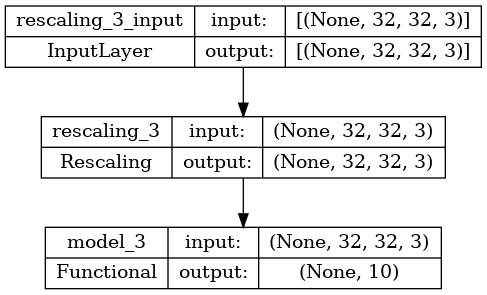

In [6]:
# Get the simple dense model
model_den = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255),
    simple_dense_model(shape=IMG_SHAPE)
])

# Compile and train the model
wrap_simple_den = ModelWrapper(model_den, tf.keras.optimizers.Adamax(learning_rate=0.001))

t_start = time.time()
history_dense = wrap_simple_den.fit(X_train, 
                    y_train, 
                    batch_size=BATCH_SIZE, 
                    epochs=40, 
                    validation_data=(X_valid,y_valid),
                    )
t_end = time.time() - t_start

training_times["simple_dense"] = t_end
accuracies["simple_dense"] = history_dense["accuracy"][-1]
test_accuracies["simple_dense"] = wrap_simple_den.best_evaluate(X_test, y_test)

tf.keras.utils.plot_model(wrap_simple_den.get_model(), show_shapes=True)

<Figure size 1400x1000 with 0 Axes>

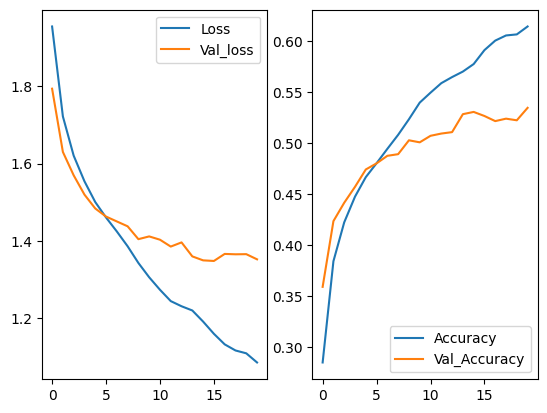

In [7]:
# Plot training
plot_history(
    (history_dense["loss"],
     history_dense["val_loss"],
     history_dense["accuracy"],
     history_dense["val_accuracy"])
)

#### Simple Convolutional model

Starting training
Epoch number 0, training time: 8.61s -->  loss: 2.0241, accuracy: 0.2310, val_loss: 1.8671, val_accuracy: 0.2862
Epoch number 1, training time: 6.94s -->  loss: 1.8023, accuracy: 0.3089, val_loss: 1.7466, val_accuracy: 0.3338
Epoch number 2, training time: 7.42s -->  loss: 1.7244, accuracy: 0.3395, val_loss: 1.6779, val_accuracy: 0.3574
Epoch number 3, training time: 7.45s -->  loss: 1.6776, accuracy: 0.3611, val_loss: 1.6545, val_accuracy: 0.3738
Epoch number 4, training time: 7.47s -->  loss: 1.6488, accuracy: 0.3746, val_loss: 1.6218, val_accuracy: 0.3892
Epoch number 5, training time: 7.45s -->  loss: 1.6201, accuracy: 0.3920, val_loss: 1.6081, val_accuracy: 0.3986
Epoch number 6, training time: 7.18s -->  loss: 1.5931, accuracy: 0.4027, val_loss: 1.5683, val_accuracy: 0.4198
Epoch number 7, training time: 6.53s -->  loss: 1.5636, accuracy: 0.4193, val_loss: 1.5391, val_accuracy: 0.4290
Epoch number 8, training time: 6.7s -->  loss: 1.5362, accuracy: 0.4324, val_l

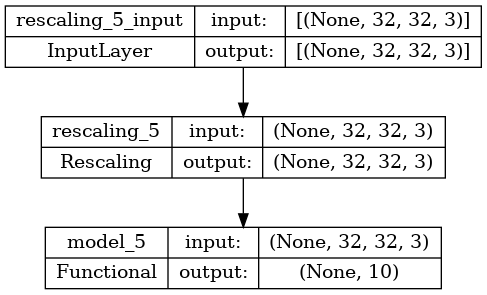

In [10]:
# %% Simple convolutional model
model_simple_conv = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255),
    simple_conv_model(shape=IMG_SHAPE)
])

# Compile and train the model
wrap_simple_conv = ModelWrapper(model_simple_conv, tf.keras.optimizers.Adamax(learning_rate=0.001))

t_start = time.time()
history_simple_conv = wrap_simple_conv.fit(X_train, 
                    y_train, 
                    batch_size=BATCH_SIZE, 
                    epochs=50, 
                    validation_data=(X_valid,y_valid),
                    )
t_end = time.time() - t_start

training_times["simple_conv"] = t_end
accuracies["simple_conv"] = history_simple_conv["accuracy"][-1]
test_accuracies["simple_conv"] = wrap_simple_conv.best_evaluate(X_test, y_test)

tf.keras.utils.plot_model(wrap_simple_conv.get_model(), show_shapes=True)

<Figure size 1400x1000 with 0 Axes>

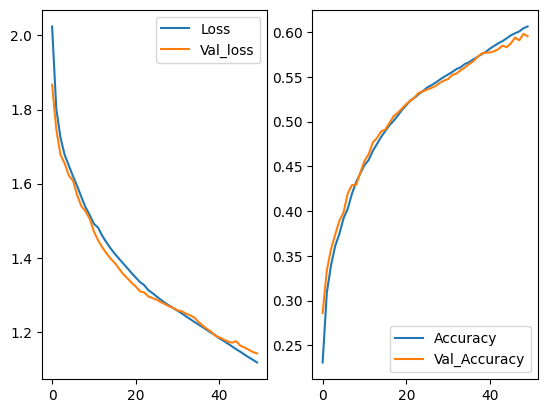

In [11]:

# Plot training
plot_history(
    (history_simple_conv["loss"],
     history_simple_conv["val_loss"],
     history_simple_conv["accuracy"],
     history_simple_conv["val_accuracy"])
)

#### Optimized convolutional model

In [12]:
# %% Optimized convolutional model
model_opt_conv = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.RandomFlip("horizontal"),
    conv_model(shape=IMG_SHAPE)
])

# Compile and train the model
wrap_opt_conv = ModelWrapper(model_opt_conv, tf.keras.optimizers.Adamax(learning_rate=0.001))

t_start = time.time()
history_opt_conv = wrap_opt_conv.fit(X_train, 
                    y_train, 
                    batch_size=BATCH_SIZE, 
                    epochs=40, 
                    validation_data=(X_valid,y_valid),
                    )
t_end = time.time() - t_start

training_times["optimised_conv"] = t_end
accuracies["optimised_conv"] = history_opt_conv["accuracy"][-1]
test_accuracies["optimised_conv"] = wrap_opt_conv.best_evaluate(X_test, y_test)

tf.keras.utils.plot_model(history_opt_conv.get_model(), show_shapes=True)

Starting training


2023-05-08 12:36:26.728527: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_6/model_6/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-05-08 12:36:39.318277: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_6/model_6/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch number 0, training time: 13.79s -->  loss: 2.5758, accuracy: 0.2341, val_loss: 2.3948, val_accuracy: 0.1000
Epoch number 1, training time: 10.95s -->  loss: 1.9887, accuracy: 0.3270, val_loss: 2.5784, val_accuracy: 0.1000
Epoch number 2, training time: 10.44s -->  loss: 1.7533, accuracy: 0.3837, val_loss: 2.4356, val_accuracy: 0.1194
Epoch number 3, training time: 10.9s -->  loss: 1.6030, accuracy: 0.4270, val_loss: 2.0896, val_accuracy: 0.2180
Epoch number 4, training time: 11.0s -->  loss: 1.4876, accuracy: 0.4631, val_loss: 1.6945, val_accuracy: 0.3632
Epoch number 5, training time: 10.67s -->  loss: 1.3985, accuracy: 0.4947, val_loss: 1.4707, val_accuracy: 0.4690
Epoch number 6, training time: 10.66s -->  loss: 1.3241, accuracy: 0.5252, val_loss: 1.4094, val_accuracy: 0.4852
Epoch number 7, training time: 10.22s -->  loss: 1.2573, accuracy: 0.5489, val_loss: 1.2516, val_accuracy: 0.5454
Epoch number 8, training time: 11.31s -->  loss: 1.2084, accuracy: 0.5667, val_loss: 1.212

In [ ]:
# Plot training
plot_history(
    (history_opt_conv["loss"],
     history_opt_conv["val_loss"],
     history_opt_conv["accuracy"],
     history_opt_conv["val_accuracy"])
)

#### Residual convolutional model

In [ ]:
# %% Residual convolutional model
model_resnet = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.RandomFlip("horizontal"),
    residual_model(shape=IMG_SHAPE)
])

# Compile and train the model
wrap_resnet = ModelWrapper(model_resnet, tf.keras.optimizers.Adamax(learning_rate=0.001))

t_start = time.time()
history_resnet = wrap_resnet.fit(X_train, 
                    y_train, 
                    batch_size=BATCH_SIZE, 
                    epochs=25, 
                    validation_data=(X_valid,y_valid),
                    )
t_end = time.time() - t_start

training_times["residual_conv"] = t_end
accuracies["residual_conv"] = history_resnet["accuracy"][-1]
test_accuracies["residual_conv"] = wrap_resnet.best_evaluate(X_test, y_test)

tf.keras.utils.plot_model(wrap_resnet.get_model(), show_shapes=True)

In [ ]:
# Plot training
plot_history(
    (history_resnet["loss"],
     history_resnet["val_loss"],
     history_resnet["accuracy"],
     history_resnet["val_accuracy"])
)

#### Bottleneck model

In [ ]:
# %% Bottleneck model
model_bottleneck = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    bottleneck_model(shape=IMG_SHAPE)
])

wrap_bottleneck = ModelWrapper(model_bottleneck, tf.keras.optimizers.Adamax(learning_rate=0.001))

t_start = time.time()
history_bottleneck = wrap_bottleneck.fit(X_train, 
                    y_train, 
                    batch_size=BATCH_SIZE, 
                    epochs=40, 
                    validation_data=(X_valid,y_valid),
                    )
t_end = time.time() - t_start

training_times["bottleneck"] = t_end
accuracies["bottleneck"] = history_bottleneck["accuracy"][-1]
test_accuracies["bottleneck"] = wrap_bottleneck.best_evaluate(X_test, y_test)

tf.keras.utils.plot_model(wrap_resnet.get_model(), show_shapes=True)

In [ ]:
# Plot training
plot_history(
    (history_bottleneck["loss"],
     history_bottleneck["val_loss"],
     history_bottleneck["accuracy"],
     history_bottleneck["val_accuracy"])
)

### Putting it all together